## TASK 4 - Face Mask Detection using Convolutional Neural Networks

Group Number: #INSERT HERE


In [22]:
%load_ext autoreload
%autoreload 1
%aimport my_model, utils, my_datamodule, my_model, my_trainer
%matplotlib inline
import os

import numpy as np
import torch
from torchinfo import summary

import my_datamodule
import my_model
import my_trainer
import utils

torch.manual_seed(30)
np.random.seed(30)

if not os.path.exists(os.path.join(os.getcwd(), 'results')):
    os.makedirs(os.path.join(os.getcwd(), 'results'))

# Check GPU connection
gpu_active = torch.cuda.is_available()
print("GPU is used" if gpu_active else "CPU is used")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU is used


### 1. Data import and Preparation

In TASK3 we used a common computer vision processing step for classification problems in computer vision - manual feature extraction. This time we want to use a learning approach which does not need handcrafted inputs. 

Implement the **get_transforms** method. Make sure it returns a transformation that maps input images to tensor values and resizes them to a square image.

For simplicity and actuality you will detect if a person wears a face mask or not. Follow the instructions in the assignment description. Implement the get_transform method of **my_datamodule.DataModule** and create an instance of **DataModule**. Use an image size of 64 and a batch_size around **64**. Depending on your processor you can increase the amount of threads that load data with the parameter **num_worker**. For example use **num_workers=4** to start four worker threads for data loading and preprocessing. 

In [40]:
from my_datamodule import DataModule

data_module = DataModule(
    data_dir="data",   
    img_size=64,         
    batch_size=32,        
    num_workers=4,       
    gray=True             
)

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print(f"Train loader size: {len(train_loader)}")
print(f"Validation loader size: {len(val_loader)}")
print(f"Test loader size: {len(test_loader)}")


Train loader size: 142
Validation loader size: 48
Test loader size: 1


### 2. Simple Face Mask Detection CNN
#### 2.1 Network Structure

This section will familiarize you with the steps of creating a deep artificial neural network from scratch. Implement the **__init__** and **forward** methods of **my_model.MaskClassifier** according to the instructions.

Create a simple classification model using ***model=my_model.MaskClassifier(..)***. Set the image size to **64** (the dataset will be proccessed to squared images) and drop out value to **0**.

Take a look at the structure of your model by calling ***summary(model, (32, 3, img_size, img_size))***

In [24]:
from my_model import MaskClassifier
from torchinfo import summary

model = MaskClassifier(name="mask_cnn", img_size=64, dropout=0)

summary(model, input_size=(32, 3, 64, 64)) 


Layer (type:depth-idx)                   Output Shape              Param #
MaskClassifier                           [32, 1]                   --
├─Conv2d: 1-1                            [32, 32, 64, 64]          896
├─MaxPool2d: 1-2                         [32, 32, 32, 32]          --
├─Conv2d: 1-3                            [32, 64, 32, 32]          18,496
├─MaxPool2d: 1-4                         [32, 64, 16, 16]          --
├─Linear: 1-5                            [32, 128]                 2,097,280
├─Dropout: 1-6                           [32, 128]                 --
├─Linear: 1-7                            [32, 1]                   129
Total params: 2,116,801
Trainable params: 2,116,801
Non-trainable params: 0
Total mult-adds (M): 790.63
Input size (MB): 1.57
Forward/backward pass size (MB): 50.36
Params size (MB): 8.47
Estimated Total Size (MB): 60.40

***
#### Q1: Take a look at the structure of the MaskClassifier CNN. What does the column 'Output Shape' represent? What does the column Param represent? Why is the shape decreasing? Finally, explain why the last layer has length 1. 

##### The 'Output Shape' column represents how the tensor's shape is changed after each layer based on the convolution and pooling operations.
##### The 'Param' column is the number of trainable parameters given in each layer. These parameters are base on kernel size and input/output channels.
##### The shape decreases as spatial dimensions are reduced by pooling and convolution to extract meaningful features while reducing computational load.
##### The final layer has a lenght of 1 because the model performs a binary classification where the output represents the probability of belonging to the positive class 

#### 2.2 Training 

In this step you will train the model with the training and validation data set iterator. The **my_trainer** module provides functionality for training and logging the learning progress.

First create a trainer instance using my_trainer.Trainer(...) and pass the previosuly created model and datamodule to it. If you have a device that supports cuda you can pass **gpu=True** to speed up training. Use trainer.fit(...) to start the training process. Depending on wether you use a GPU or CPU and the number of epochs, the training can take a while. Start with a learning rate of **0.0001** and **50** epochs. The loss should decrease and the accuracy on the validation should increase. The weights of the best model are saved in separate files in your results directory automatically.

In [ ]:
from PIL import Image
import os
import sys
import torch.multiprocessing as mp
from my_trainer import Trainer
from my_model import MaskClassifier
from my_datamodule import DataModule

# # Convert RGBA images to RGB
# for img_path in rgba_images:
#     with Image.open(img_path) as img:
#         if img.mode == "RGBA":
#             print(f"Converting {img_path} from RGBA to RGB")
#             rgb_img = img.convert("RGB")
#             rgb_img.save(img_path)  # Overwrite the original image

# rgba_images = []
# for folder in ["train/face", "train/mask"]:
#     folder_path = os.path.join("data", folder)
#     for file in os.listdir(folder_path):
#         img_path = os.path.join(folder_path, file)
#         with Image.open(img_path) as img:
#             if img.mode == "RGBA":
#                 rgba_images.append(img_path)

# print(f"Found {len(rgba_images)} RGBA images.")

mp.set_start_method("spawn", force=True)

sys.path.append(os.path.abspath("TASK4"))

IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

model = MaskClassifier(name="mask_cnn", img_size=IMG_SIZE, dropout=0)
data_module = DataModule(
    data_dir="data",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    augmented=True,
    num_workers=0, 
    gray=True
)

trainer = Trainer(model=model, datamodule=data_module, gpu=torch.cuda.is_available())
trainer.fit(epochs=EPOCHS, lr=LEARNING_RATE)


#### 1.3 Performance Evaluation 

Test the model with **trainer.test()** and plot the model performance of the last training session with ***plot_performance(..)***.

***Submission:*** Save the output of ***trainer.plot_performance(..)*** as **task4_model_simple.png**

/opt/homebrew/Caskroom/miniforge/base/envs/torch_env/lib/python3.9/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.1491, Test Accuracy: 94.77%
Performance plot saved as task4_model_simple.png


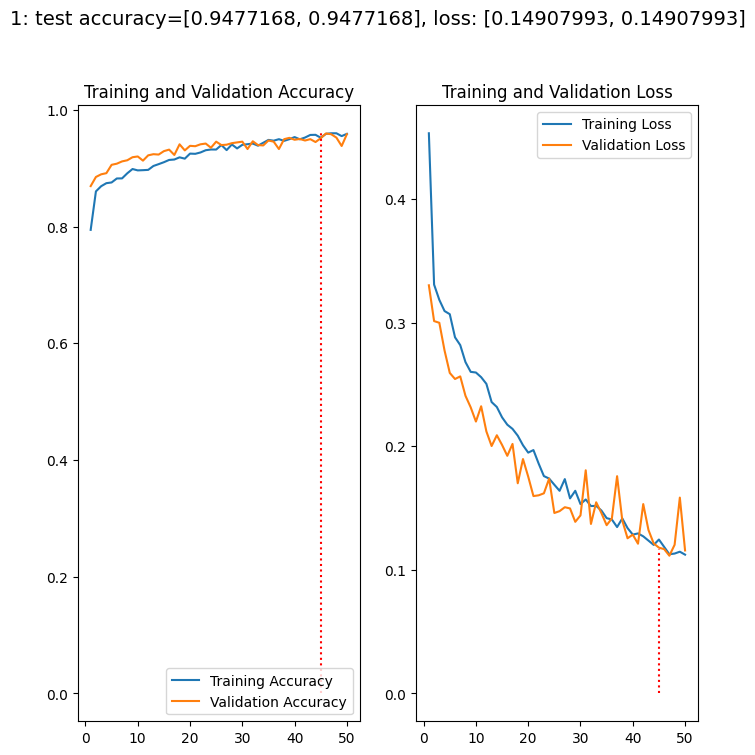

In [26]:
import matplotlib.pyplot as plt

test_loss, test_acc = trainer.test()
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

trainer.plot_performance(name="task4_model_simple", group_no=1)

plt.savefig("task4_model_simple.png")
print("Performance plot saved as task4_model_simple.png")

***
#### Q2: What values are optimized during the training process of a CNN? Why isn't the validation accuracy increasing after some time? Why do we use a validation dataset?

- During the training process of a CNN the optimized values are : weights and biases in convolutional and fully connected layers.
- The validation accuracy is not increasing after some time due to overfitting, learning rate issues, insuficient model complexity or data problems.
- We use a validation dataset to help monitor generalization performace, prevent overfitting an tune parameters evectively.

### 3 Regularization
#### 3.1 Network Structure

With the basic model you should have achieved a test accuracy of about 95% As you can see on the last model performance, the simple model starts to overfit on the training data. One option to improve generalization is to use regularization. You can add batch normalization and dropout to do so. Update the **MaskClassifier** to include those techniques. Add dropout and batch normalization before suitable layers. Use the dropout parameter passed to the constructor for the dropout rate.

Create a new model with a dropout rate of **dropout=0.5** or **batch_norm=True** and name it **'model_regularized'**. Take a look at the structure of your model by calling ***summary(model2)***. 


In [27]:
from my_model import MaskClassifier
from torchinfo import summary

model2 = MaskClassifier(name="model_regularized", img_size=64, dropout=0.5, batch_norm=True)

summary(model2, input_size=(32, 3, 64, 64)) 

Layer (type:depth-idx)                   Output Shape              Param #
MaskClassifier                           [32, 1]                   --
├─Conv2d: 1-1                            [32, 32, 64, 64]          896
├─MaxPool2d: 1-2                         [32, 32, 32, 32]          --
├─Conv2d: 1-3                            [32, 64, 32, 32]          18,496
├─MaxPool2d: 1-4                         [32, 64, 16, 16]          --
├─Linear: 1-5                            [32, 128]                 2,097,280
├─Dropout: 1-6                           [32, 128]                 --
├─Linear: 1-7                            [32, 1]                   129
Total params: 2,116,801
Trainable params: 2,116,801
Non-trainable params: 0
Total mult-adds (M): 790.63
Input size (MB): 1.57
Forward/backward pass size (MB): 50.36
Params size (MB): 8.47
Estimated Total Size (MB): 60.40

***
#### Q3: Compare the network structure of the model with and without regularization. What will be the effect of the dropout rate you have chosen? What is the effect of batch normalization?

##### The chosen dropout rate will have the effect of providing a balanced trade-off between regulation and trainig efficiency.
##### Batch normalisation stabilizes training by normalizing activators, reducing sensitivity to paramater initialization and learning rate. Aditionally, it improves generalization and prevents overfitting, especially for deeper networks.

#ANSWER HERE

#### 3.2 Training the network

Create a new Trainer object called **trainer2**.
Train the second network, using the same learning rate you used for the first model and set the number of epochs around **50**. 
You can use the same Data Module as for the simple model.


In [ ]:
from my_model import MaskClassifier
from my_trainer import Trainer

model2 = MaskClassifier(name="model_regularized", img_size=64, dropout=0.5, batch_norm=True)

trainer2 = Trainer(model=model2, datamodule=data_module, gpu=torch.cuda.is_available())
trainer2.fit(epochs=50, lr=0.0001)

In [29]:
test2_loss, test2_acc = trainer2.test()
print(f"Test Loss: {test2_loss:.4f}, Test Accuracy: {test2_acc * 100:.2f}%")

Test Loss: 0.1487, Test Accuracy: 95.17%


#### 3.3 Plot Performance

Plot the performance of the second model with ***trainer2.plot_performance(..)***.

***Submission:*** Save the output of ***trainer2.plot_performance(..)*** as **task4_model_regularized.png**

Performance plot saved as task4_model_regularized.png


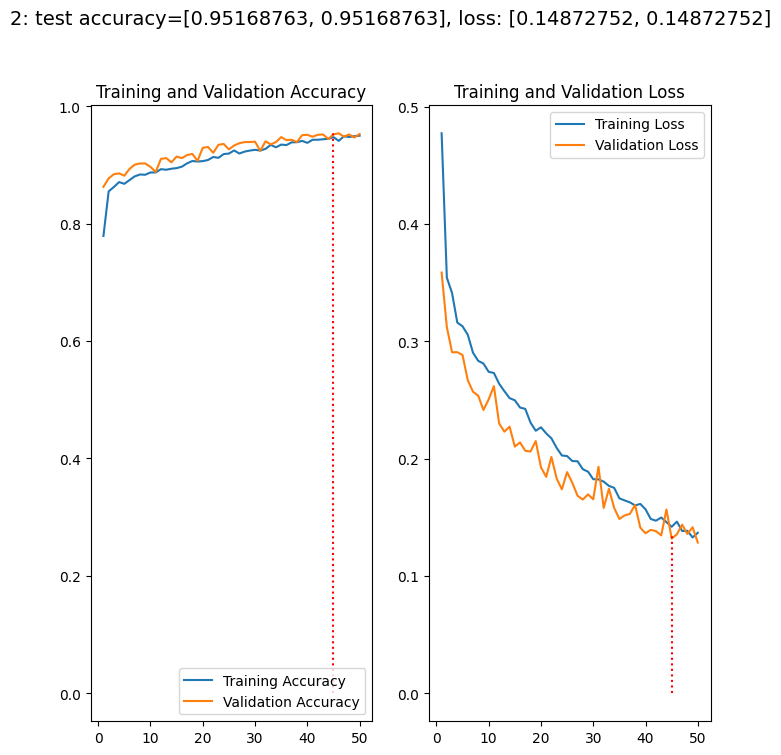

In [30]:
import matplotlib.pyplot as plt
trainer2.plot_performance(name="task4_model_regularized", group_no=2)

plt.savefig("task4_model_regularized.png")
print("Performance plot saved as task4_model_regularized.png")

***
#### Q4: Compare the performance of the model with and without regularization. Where do you see improvements?


#### Performance analysis
##### Validation Loss
- Simple model: Decreases up to one point, then increases again after some epochs due to overfitting.
- Regularized model: Decreses evenly which indicates improved generalization.
##### Validation Accuracy
- Simple model: Stagnates after a while.
- Regularized model: Improves during the epochs.
##### Test Accuracy
- Simple model: 94.77%
- Regularized model: 95.17%

### 4 Data Augmentation
#### 4.1 Advanced Data Pre-Processing
You will enhance generalization of the network by artificially adding more variety to the training data. Implement data augmentation in **get_transforms** method of **my_datamodule**. Have a look at [torchvision transforms](https://pytorch.org/vision/stable/transforms.html) and choose at least three data augmentation techniques.

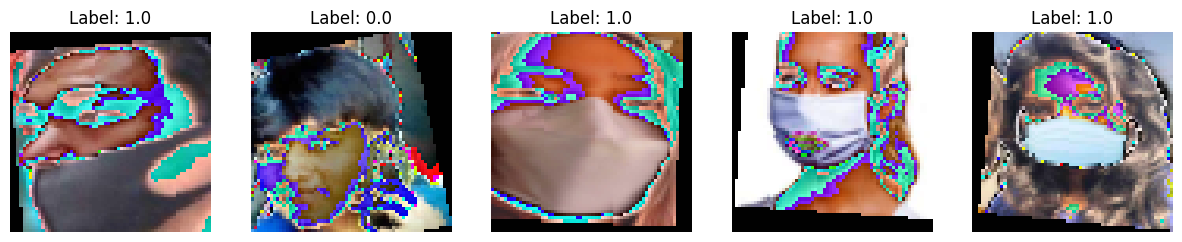

In [31]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

train_loader = data_module.train_dataloader()
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    augmented_img = images[i]
    axes[i].imshow(to_pil_image(augmented_img))
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()


#### 4.2 Activation Maps before Training
Create a model with a dropout rate of **60%** and batch normalization. Use a learning rate of approximately **0.0007**. Call the model **'model_augmented'**.

The convolutional layers in the network are initialised with random values. We are going to compare the activation maps before and after the training process. Use ***utils.plot_activation_maps(..)*** to plot some untrained activation maps and filter kernels of the third model. 

Get two image sample of the augmented training dataset with **sample=dm2.train_dataset[...][0]**, one with a mask and one without a mask. Pass each image sample to ***utils.plot_activation_maps(..)***.


***Submission:*** Save the activation maps of the untrained model as **task4_face_activation_maps_before.png** and **task4_mask_activation_maps_before.png** using ***utils.plot_activation_maps(..)***



Total convolutional layers: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total convolutional layers: 2


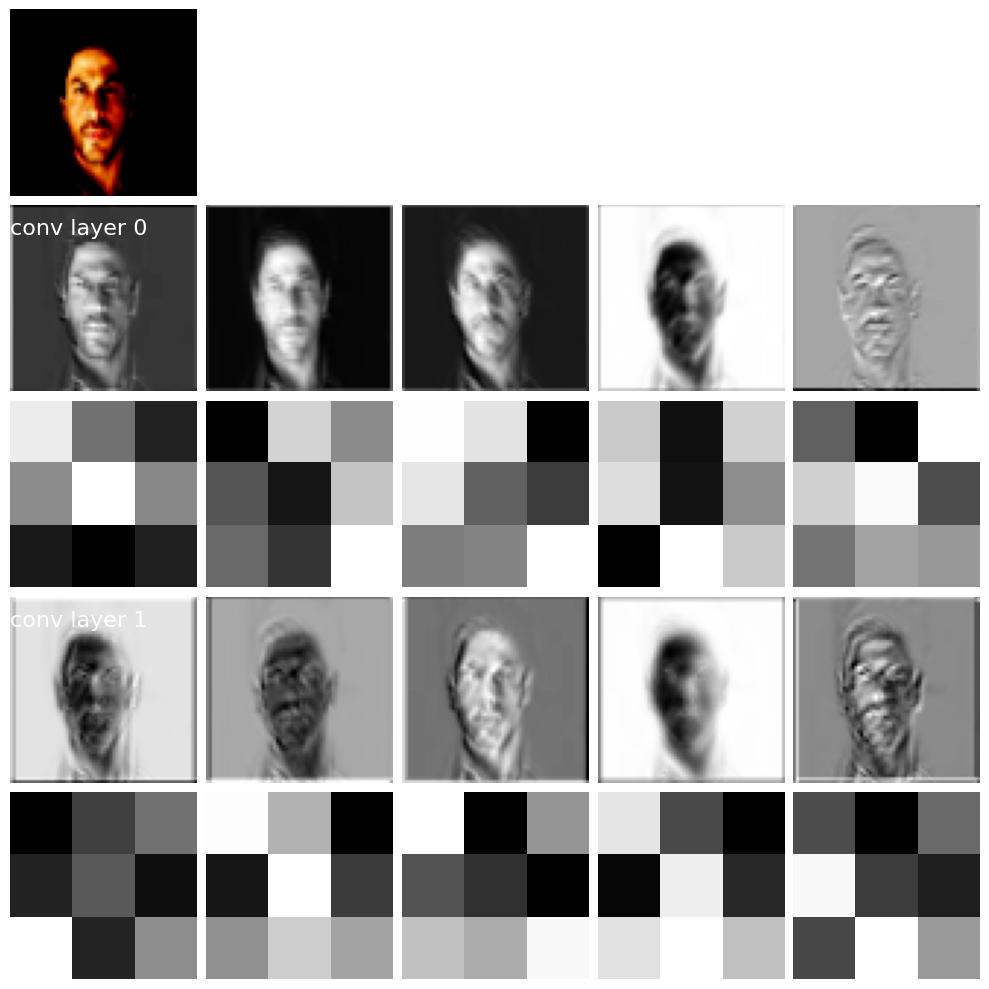

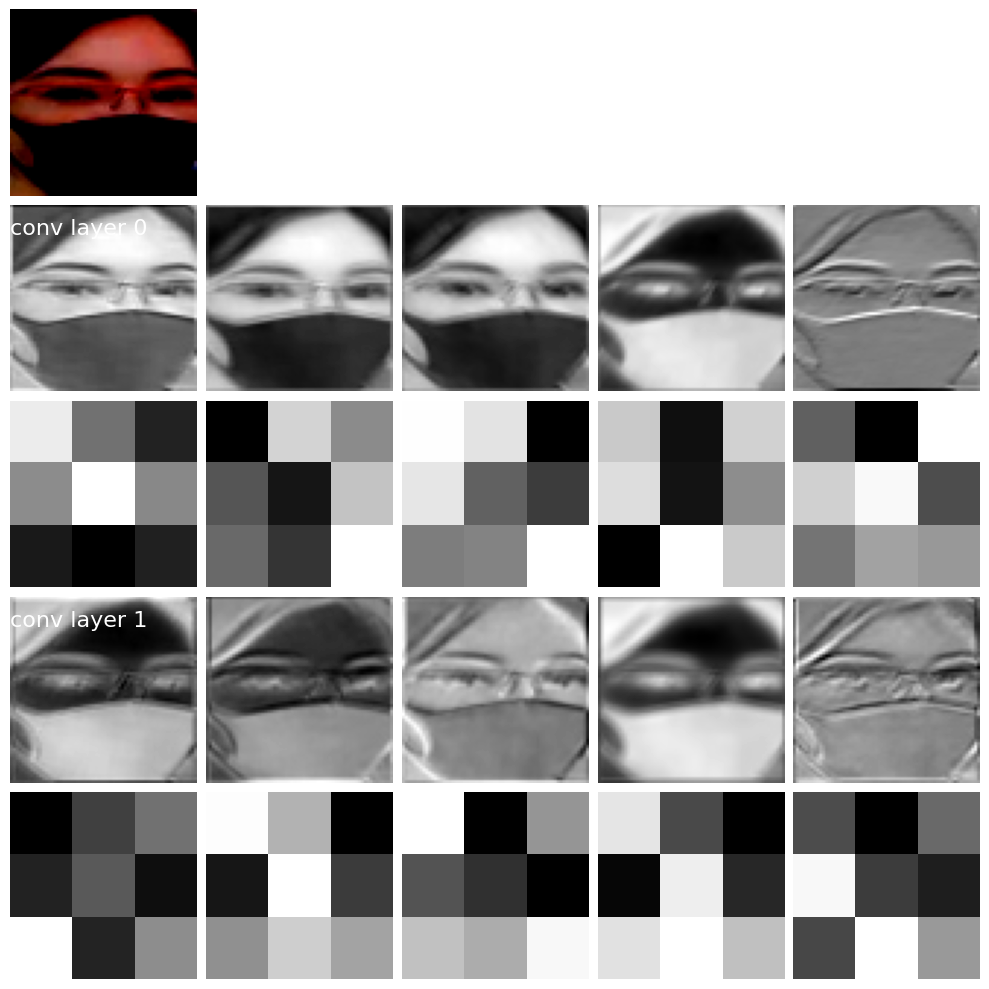

In [47]:
from my_model import MaskClassifier
from utils import plot_activation_maps

model_augmented = MaskClassifier(name="model_augmented", img_size=64, dropout=0.6, batch_norm=True)

# for idx in range(len(data_module.train_dataset)):
#     _, label = data_module.train_dataset[idx]
#     print(f"Index: {idx}, Label: {label}")

sample_with_mask = data_module.train_dataset[0][0]
sample_without_mask = data_module.train_dataset[3456][0]

plot_activation_maps(model_augmented, sample_with_mask, "task4_face_activation_maps_before")
plot_activation_maps(model_augmented, sample_without_mask, "task4_mask_activation_maps_before")

import matplotlib.pyplot as plt
plt.savefig("task4_face_activation_maps_before.png")
plt.savefig("task4_mask_activation_maps_before.png")

#### 4.3 Training the network
Create a third trainer object and train the third network here using the augmented datamodule. Set the epochs to around **100**.

Depending on your hardware this might take longer than the last training sessions.

In [42]:
from my_datamodule import DataModule
from my_model import MaskClassifier
from my_trainer import Trainer
import matplotlib.pyplot as plt

data_module_augmented = DataModule(
    data_dir="data",
    img_size=64,
    batch_size=32,
    augmented=True,
    num_workers=0,
    gray=True
)

model_augmented = MaskClassifier(name="model_augmented", img_size=64, dropout=0.6, batch_norm=True)

trainer3 = Trainer(model=model_augmented, datamodule=data_module_augmented, gpu=torch.cuda.is_available())
trainer3.fit(epochs=100, lr=0.0007)

Epoch 0: 100%|██████████| 142/142 [00:12<00:00, 11.01it/s]


Epoch 0 Training: Loss: 0.41703757643699646 Accuracy: 0.812859058380127
Epoch 0 Validation: Loss: 0.3593497574329376 Accuracy: 0.8577008843421936


Epoch 1: 100%|██████████| 142/142 [00:12<00:00, 11.32it/s]


Epoch 1 Training: Loss: 0.3383670747280121 Accuracy: 0.8522400856018066
Epoch 1 Validation: Loss: 0.2516731917858124 Accuracy: 0.8948102593421936


Epoch 2: 100%|██████████| 142/142 [00:12<00:00, 11.13it/s]


Epoch 2 Training: Loss: 0.2859927713871002 Accuracy: 0.8795403838157654
Epoch 2 Validation: Loss: 0.2211930751800537 Accuracy: 0.9071800708770752


Epoch 3: 100%|██████████| 142/142 [00:12<00:00, 11.24it/s]


Epoch 3 Training: Loss: 0.25758352875709534 Accuracy: 0.8912041187286377
Epoch 3 Validation: Loss: 0.19968681037425995 Accuracy: 0.9156436324119568


Epoch 4: 100%|██████████| 142/142 [00:13<00:00, 10.77it/s]


Epoch 4 Training: Loss: 0.2382761389017105 Accuracy: 0.90132737159729
Epoch 4 Validation: Loss: 0.20314109325408936 Accuracy: 0.9175967574119568


Epoch 5: 100%|██████████| 142/142 [00:12<00:00, 11.11it/s]


Epoch 5 Training: Loss: 0.23153068125247955 Accuracy: 0.9058792591094971
Epoch 5 Validation: Loss: 0.2012266367673874 Accuracy: 0.9228050708770752


Epoch 6: 100%|██████████| 142/142 [00:13<00:00, 10.90it/s]


Epoch 6 Training: Loss: 0.2123805284500122 Accuracy: 0.9134312868118286
Epoch 6 Validation: Loss: 0.17613525688648224 Accuracy: 0.9286644458770752


Epoch 7: 100%|██████████| 142/142 [00:13<00:00, 10.87it/s]


Epoch 7 Training: Loss: 0.20461784303188324 Accuracy: 0.9208440780639648
Epoch 7 Validation: Loss: 0.16270528733730316 Accuracy: 0.9388020634651184


Epoch 8: 100%|██████████| 142/142 [00:13<00:00, 10.81it/s]


Epoch 8 Training: Loss: 0.18481504917144775 Accuracy: 0.9277358651161194
Epoch 8 Validation: Loss: 0.14679697155952454 Accuracy: 0.9423363208770752


Epoch 9: 100%|██████████| 142/142 [00:13<00:00, 10.83it/s]


Epoch 9 Training: Loss: 0.17161938548088074 Accuracy: 0.9327974915504456
Epoch 9 Validation: Loss: 0.16023096442222595 Accuracy: 0.9494977593421936


Epoch 10: 100%|██████████| 142/142 [00:13<00:00, 10.77it/s]


Epoch 10 Training: Loss: 0.16209949553012848 Accuracy: 0.9388898611068726
Epoch 10 Validation: Loss: 0.14126060903072357 Accuracy: 0.958984375


Epoch 11: 100%|██████████| 142/142 [00:13<00:00, 10.58it/s]


Epoch 11 Training: Loss: 0.153224915266037 Accuracy: 0.9418898224830627
Epoch 11 Validation: Loss: 0.12438380718231201 Accuracy: 0.9527530074119568


Epoch 12: 100%|██████████| 142/142 [00:13<00:00, 10.64it/s]


Epoch 12 Training: Loss: 0.1491236686706543 Accuracy: 0.9483528733253479
Epoch 12 Validation: Loss: 0.11826365441083908 Accuracy: 0.9618675708770752


Epoch 13: 100%|██████████| 142/142 [00:13<00:00, 10.54it/s]


Epoch 13 Training: Loss: 0.13672374188899994 Accuracy: 0.952464759349823
Epoch 13 Validation: Loss: 0.10710438340902328 Accuracy: 0.9664248824119568


Epoch 14: 100%|██████████| 142/142 [00:13<00:00, 10.61it/s]


Epoch 14 Training: Loss: 0.130230113863945 Accuracy: 0.9496038556098938
Epoch 14 Validation: Loss: 0.11956840753555298 Accuracy: 0.9618675708770752


Epoch 15: 100%|██████████| 142/142 [00:13<00:00, 10.73it/s]


Epoch 15 Training: Loss: 0.13278809189796448 Accuracy: 0.9498933553695679
Epoch 15 Validation: Loss: 0.10283571481704712 Accuracy: 0.9605655074119568


Epoch 16: 100%|██████████| 142/142 [00:13<00:00, 10.66it/s]


Epoch 16 Training: Loss: 0.11471264809370041 Accuracy: 0.9575958251953125
Epoch 16 Validation: Loss: 0.11175819486379623 Accuracy: 0.9657738208770752


Epoch 17: 100%|██████████| 142/142 [00:13<00:00, 10.30it/s]


Epoch 17 Training: Loss: 0.11208479851484299 Accuracy: 0.9615570902824402
Epoch 17 Validation: Loss: 0.10269618779420853 Accuracy: 0.9612165093421936


Epoch 18: 100%|██████████| 142/142 [00:13<00:00, 10.38it/s]


Epoch 18 Training: Loss: 0.11215118318796158 Accuracy: 0.9634683132171631
Epoch 18 Validation: Loss: 0.09286043792963028 Accuracy: 0.9664248824119568


Epoch 19: 100%|██████████| 142/142 [00:13<00:00, 10.42it/s]


Epoch 19 Training: Loss: 0.10976316034793854 Accuracy: 0.9619278311729431
Epoch 19 Validation: Loss: 0.12607885897159576 Accuracy: 0.9537760615348816


Epoch 20: 100%|██████████| 142/142 [00:13<00:00, 10.40it/s]


Epoch 20 Training: Loss: 0.10505268722772598 Accuracy: 0.9583256840705872
Epoch 20 Validation: Loss: 0.10439463704824448 Accuracy: 0.9599144458770752


Epoch 21: 100%|██████████| 142/142 [00:13<00:00, 10.47it/s]


Epoch 21 Training: Loss: 0.10621559619903564 Accuracy: 0.9638274312019348
Epoch 21 Validation: Loss: 0.10080798715353012 Accuracy: 0.966796875


Epoch 22: 100%|██████████| 142/142 [00:14<00:00,  9.99it/s]


Epoch 22 Training: Loss: 0.09789480268955231 Accuracy: 0.9654489159584045
Epoch 22 Validation: Loss: 0.08877617120742798 Accuracy: 0.9703311324119568


Epoch 23: 100%|██████████| 142/142 [00:14<00:00,  9.70it/s]


Epoch 23 Training: Loss: 0.09344430267810822 Accuracy: 0.9691901206970215
Epoch 23 Validation: Loss: 0.08237484842538834 Accuracy: 0.9657738208770752


Epoch 24: 100%|██████████| 142/142 [00:14<00:00,  9.64it/s]


Epoch 24 Training: Loss: 0.09632449597120285 Accuracy: 0.9674295783042908
Epoch 24 Validation: Loss: 0.08051667362451553 Accuracy: 0.9683780074119568


Epoch 25: 100%|██████████| 142/142 [00:14<00:00,  9.57it/s]


Epoch 25 Training: Loss: 0.09951489418745041 Accuracy: 0.967348575592041
Epoch 25 Validation: Loss: 0.08278447389602661 Accuracy: 0.9670758843421936


Epoch 26: 100%|██████████| 142/142 [00:14<00:00,  9.64it/s]


Epoch 26 Training: Loss: 0.09604823589324951 Accuracy: 0.9650782346725464
Epoch 26 Validation: Loss: 0.10227203369140625 Accuracy: 0.9651227593421936


Epoch 27: 100%|██████████| 142/142 [00:16<00:00,  8.83it/s]


Epoch 27 Training: Loss: 0.09019209444522858 Accuracy: 0.9716803431510925
Epoch 27 Validation: Loss: 0.0905131921172142 Accuracy: 0.9664248824119568


Epoch 28: 100%|██████████| 142/142 [00:14<00:00,  9.51it/s]


Epoch 28 Training: Loss: 0.08752892911434174 Accuracy: 0.9688194394111633
Epoch 28 Validation: Loss: 0.08370181918144226 Accuracy: 0.96875


Epoch 29: 100%|██████████| 142/142 [00:15<00:00,  9.31it/s]


Epoch 29 Training: Loss: 0.08189614117145538 Accuracy: 0.9720510840415955
Epoch 29 Validation: Loss: 0.07636244595050812 Accuracy: 0.9761905074119568


Epoch 30: 100%|██████████| 142/142 [00:16<00:00,  8.45it/s]


Epoch 30 Training: Loss: 0.091909259557724 Accuracy: 0.966549277305603
Epoch 30 Validation: Loss: 0.08266783505678177 Accuracy: 0.9677269458770752


Epoch 31: 100%|██████████| 142/142 [00:16<00:00,  8.72it/s]


Epoch 31 Training: Loss: 0.0836571455001831 Accuracy: 0.9691901206970215
Epoch 31 Validation: Loss: 0.0964905321598053 Accuracy: 0.9641926884651184


Epoch 32: 100%|██████████| 142/142 [00:16<00:00,  8.83it/s]


Epoch 32 Training: Loss: 0.0767802819609642 Accuracy: 0.9729313254356384
Epoch 32 Validation: Loss: 0.07969265431165695 Accuracy: 0.9690290093421936


Epoch 33: 100%|██████████| 142/142 [00:16<00:00,  8.47it/s]


Epoch 33 Training: Loss: 0.07240080833435059 Accuracy: 0.9718309640884399
Epoch 33 Validation: Loss: 0.07997723668813705 Accuracy: 0.9677269458770752


Epoch 34: 100%|██████████| 142/142 [00:16<00:00,  8.84it/s]


Epoch 34 Training: Loss: 0.0775134265422821 Accuracy: 0.9744718074798584
Epoch 34 Validation: Loss: 0.09861055761575699 Accuracy: 0.9670758843421936


Epoch 35: 100%|██████████| 142/142 [00:16<00:00,  8.47it/s]


Epoch 35 Training: Loss: 0.08723493665456772 Accuracy: 0.973660945892334
Epoch 35 Validation: Loss: 0.07885890454053879 Accuracy: 0.9716331958770752


Epoch 36: 100%|██████████| 142/142 [00:16<00:00,  8.69it/s]


Epoch 36 Training: Loss: 0.07802823930978775 Accuracy: 0.9746919274330139
Epoch 36 Validation: Loss: 0.07641761749982834 Accuracy: 0.9742373824119568


Epoch 37: 100%|██████████| 142/142 [00:16<00:00,  8.78it/s]


Epoch 37 Training: Loss: 0.07569628208875656 Accuracy: 0.9744718074798584
Epoch 37 Validation: Loss: 0.09300408512353897 Accuracy: 0.9651227593421936


Epoch 38: 100%|██████████| 142/142 [00:16<00:00,  8.56it/s]


Epoch 38 Training: Loss: 0.07070845365524292 Accuracy: 0.9744718074798584
Epoch 38 Validation: Loss: 0.07578157633543015 Accuracy: 0.9722842574119568


Epoch 39: 100%|██████████| 142/142 [00:16<00:00,  8.71it/s]


Epoch 39 Training: Loss: 0.0718630999326706 Accuracy: 0.9768925905227661
Epoch 39 Validation: Loss: 0.07200350612401962 Accuracy: 0.9729352593421936


Epoch 40: 100%|██████████| 142/142 [00:16<00:00,  8.67it/s]


Epoch 40 Training: Loss: 0.07409807294607162 Accuracy: 0.9746919274330139
Epoch 40 Validation: Loss: 0.08673413842916489 Accuracy: 0.9709821343421936


Epoch 41: 100%|██████████| 142/142 [00:16<00:00,  8.62it/s]


Epoch 41 Training: Loss: 0.06507642567157745 Accuracy: 0.9754215478897095
Epoch 41 Validation: Loss: 0.07200080156326294 Accuracy: 0.9729352593421936


Epoch 42: 100%|██████████| 142/142 [00:16<00:00,  8.59it/s]


Epoch 42 Training: Loss: 0.06916151940822601 Accuracy: 0.9746919274330139
Epoch 42 Validation: Loss: 0.10049674659967422 Accuracy: 0.9742373824119568


Epoch 43: 100%|██████████| 142/142 [00:16<00:00,  8.48it/s]


Epoch 43 Training: Loss: 0.059647977352142334 Accuracy: 0.9798229336738586
Epoch 43 Validation: Loss: 0.08174485713243484 Accuracy: 0.9768415093421936


Epoch 44: 100%|██████████| 142/142 [00:16<00:00,  8.57it/s]


Epoch 44 Training: Loss: 0.07187095284461975 Accuracy: 0.9738810658454895
Epoch 44 Validation: Loss: 0.09039419889450073 Accuracy: 0.9742373824119568


Epoch 45: 100%|██████████| 142/142 [00:46<00:00,  3.03it/s]


Epoch 45 Training: Loss: 0.0683414489030838 Accuracy: 0.9754215478897095
Epoch 45 Validation: Loss: 0.12409943342208862 Accuracy: 0.9703311324119568


Epoch 46: 100%|██████████| 142/142 [00:13<00:00, 10.51it/s]


Epoch 46 Training: Loss: 0.05873553827404976 Accuracy: 0.9797534942626953
Epoch 46 Validation: Loss: 0.07633858174085617 Accuracy: 0.9722842574119568


Epoch 47: 100%|██████████| 142/142 [00:14<00:00, 10.11it/s]


Epoch 47 Training: Loss: 0.06507988274097443 Accuracy: 0.9779929518699646
Epoch 47 Validation: Loss: 0.08611785620450974 Accuracy: 0.9722842574119568


Epoch 48: 100%|██████████| 142/142 [00:14<00:00,  9.99it/s]


Epoch 48 Training: Loss: 0.05326512083411217 Accuracy: 0.9795334339141846
Epoch 48 Validation: Loss: 0.07429426163434982 Accuracy: 0.9722842574119568


Epoch 49: 100%|██████████| 142/142 [00:15<00:00,  9.34it/s]


Epoch 49 Training: Loss: 0.06545861810445786 Accuracy: 0.9786531925201416
Epoch 49 Validation: Loss: 0.06486844271421432 Accuracy: 0.9748883843421936


Epoch 50: 100%|██████████| 142/142 [00:16<00:00,  8.62it/s]


Epoch 50 Training: Loss: 0.061711594462394714 Accuracy: 0.9790933132171631
Epoch 50 Validation: Loss: 0.07626009732484818 Accuracy: 0.9755394458770752


Epoch 51: 100%|██████████| 142/142 [16:14<00:00,  6.87s/it]   


Epoch 51 Training: Loss: 0.05678790807723999 Accuracy: 0.9808538556098938
Epoch 51 Validation: Loss: 0.07244345545768738 Accuracy: 0.9778645634651184


Epoch 52: 100%|██████████| 142/142 [00:13<00:00, 10.33it/s]


Epoch 52 Training: Loss: 0.05895359441637993 Accuracy: 0.9801936745643616
Epoch 52 Validation: Loss: 0.07123547047376633 Accuracy: 0.9761905074119568


Epoch 53: 100%|██████████| 142/142 [00:15<00:00,  9.31it/s]


Epoch 53 Training: Loss: 0.058437641710042953 Accuracy: 0.9806337952613831
Epoch 53 Validation: Loss: 0.05837521329522133 Accuracy: 0.9791666865348816


Epoch 54: 100%|██████████| 142/142 [15:12<00:00,  6.43s/it]  


Epoch 54 Training: Loss: 0.060083337128162384 Accuracy: 0.9776222109794617
Epoch 54 Validation: Loss: 0.07820499688386917 Accuracy: 0.9755394458770752


Epoch 55: 100%|██████████| 142/142 [00:13<00:00, 10.88it/s]


Epoch 55 Training: Loss: 0.057942263782024384 Accuracy: 0.9782824516296387
Epoch 55 Validation: Loss: 0.07855112105607986 Accuracy: 0.9696800708770752


Epoch 56: 100%|██████████| 142/142 [00:15<00:00,  8.96it/s]


Epoch 56 Training: Loss: 0.05193960666656494 Accuracy: 0.9815140962600708
Epoch 56 Validation: Loss: 0.07571129500865936 Accuracy: 0.9761905074119568


Epoch 57: 100%|██████████| 142/142 [15:29<00:00,  6.55s/it]  


Epoch 57 Training: Loss: 0.05088941007852554 Accuracy: 0.9826144576072693
Epoch 57 Validation: Loss: 0.07989566773176193 Accuracy: 0.9722842574119568


Epoch 58: 100%|██████████| 142/142 [00:12<00:00, 11.42it/s]


Epoch 58 Training: Loss: 0.058484673500061035 Accuracy: 0.9787921905517578
Epoch 58 Validation: Loss: 0.0868101492524147 Accuracy: 0.9748883843421936


Epoch 59: 100%|██████████| 142/142 [00:13<00:00, 10.42it/s]


Epoch 59 Training: Loss: 0.04562273994088173 Accuracy: 0.9851046204566956
Epoch 59 Validation: Loss: 0.07398756593465805 Accuracy: 0.9716331958770752


Epoch 60: 100%|██████████| 142/142 [16:34<00:00,  7.00s/it]  


Epoch 60 Training: Loss: 0.04930078983306885 Accuracy: 0.9818035960197449
Epoch 60 Validation: Loss: 0.08596506714820862 Accuracy: 0.9680989384651184


Epoch 61: 100%|██████████| 142/142 [00:12<00:00, 11.31it/s]


Epoch 61 Training: Loss: 0.04734112694859505 Accuracy: 0.9839348793029785
Epoch 61 Validation: Loss: 0.08563584089279175 Accuracy: 0.9781436324119568


Epoch 62: 100%|██████████| 142/142 [00:13<00:00, 10.19it/s]


Epoch 62 Training: Loss: 0.05747648701071739 Accuracy: 0.9799736142158508
Epoch 62 Validation: Loss: 0.07563993334770203 Accuracy: 0.9755394458770752


Epoch 63: 100%|██████████| 142/142 [15:57<00:00,  6.74s/it]  


Epoch 63 Training: Loss: 0.045100484043359756 Accuracy: 0.9846644997596741
Epoch 63 Validation: Loss: 0.05899921432137489 Accuracy: 0.9817708134651184


Epoch 64: 100%|██████████| 142/142 [00:12<00:00, 11.47it/s]


Epoch 64 Training: Loss: 0.05293330177664757 Accuracy: 0.9819542169570923
Epoch 64 Validation: Loss: 0.07483264803886414 Accuracy: 0.974609375


Epoch 65: 100%|██████████| 142/142 [00:13<00:00, 10.67it/s]


Epoch 65 Training: Loss: 0.04687957465648651 Accuracy: 0.9819542169570923
Epoch 65 Validation: Loss: 0.07879071682691574 Accuracy: 0.9716331958770752


Epoch 66: 100%|██████████| 142/142 [14:34<00:00,  6.16s/it]  


Epoch 66 Training: Loss: 0.04203520715236664 Accuracy: 0.9868651628494263
Epoch 66 Validation: Loss: 0.06652181595563889 Accuracy: 0.9778645634651184


Epoch 67: 100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Epoch 67 Training: Loss: 0.044468045234680176 Accuracy: 0.9851046204566956
Epoch 67 Validation: Loss: 0.06489867717027664 Accuracy: 0.978515625


Epoch 68: 100%|██████████| 142/142 [00:13<00:00, 10.55it/s]


Epoch 68 Training: Loss: 0.05369125306606293 Accuracy: 0.9812940359115601
Epoch 68 Validation: Loss: 0.07508981972932816 Accuracy: 0.9729352593421936


Epoch 69: 100%|██████████| 142/142 [17:42<00:00,  7.48s/it]  


Epoch 69 Training: Loss: 0.038719695061445236 Accuracy: 0.9861355423927307
Epoch 69 Validation: Loss: 0.08250343799591064 Accuracy: 0.9768415093421936


Epoch 70: 100%|██████████| 142/142 [00:12<00:00, 11.53it/s]


Epoch 70 Training: Loss: 0.037878721952438354 Accuracy: 0.9872359037399292
Epoch 70 Validation: Loss: 0.0720483586192131 Accuracy: 0.9787946343421936


Epoch 71: 100%|██████████| 142/142 [00:13<00:00, 10.81it/s]


Epoch 71 Training: Loss: 0.048098329454660416 Accuracy: 0.9815140962600708
Epoch 71 Validation: Loss: 0.08022201806306839 Accuracy: 0.9761905074119568


Epoch 72: 100%|██████████| 142/142 [16:47<00:00,  7.10s/it]  


Epoch 72 Training: Loss: 0.03935907781124115 Accuracy: 0.9868651628494263
Epoch 72 Validation: Loss: 0.06924908608198166 Accuracy: 0.9787946343421936


Epoch 73: 100%|██████████| 142/142 [00:12<00:00, 11.12it/s]


Epoch 73 Training: Loss: 0.04398956149816513 Accuracy: 0.983714759349823
Epoch 73 Validation: Loss: 0.06717134267091751 Accuracy: 0.9774925708770752


Epoch 74: 100%|██████████| 142/142 [00:13<00:00, 10.44it/s]


Epoch 74 Training: Loss: 0.05027983710169792 Accuracy: 0.9839348793029785
Epoch 74 Validation: Loss: 0.06243167445063591 Accuracy: 0.9774925708770752


Epoch 75: 100%|██████████| 142/142 [00:12<00:00, 11.01it/s]


Epoch 75 Training: Loss: 0.04559412598609924 Accuracy: 0.9826838374137878
Epoch 75 Validation: Loss: 0.08395842462778091 Accuracy: 0.9755394458770752


Epoch 76: 100%|██████████| 142/142 [00:12<00:00, 11.57it/s]


Epoch 76 Training: Loss: 0.04334963485598564 Accuracy: 0.9835641384124756
Epoch 76 Validation: Loss: 0.06454673409461975 Accuracy: 0.982421875


Epoch 77: 100%|██████████| 142/142 [00:13<00:00, 10.60it/s]


Epoch 77 Training: Loss: 0.04199669137597084 Accuracy: 0.986575722694397
Epoch 77 Validation: Loss: 0.07785042375326157 Accuracy: 0.9787946343421936


Epoch 78: 100%|██████████| 142/142 [00:12<00:00, 10.97it/s]


Epoch 78 Training: Loss: 0.04512203857302666 Accuracy: 0.9856954216957092
Epoch 78 Validation: Loss: 0.07931903749704361 Accuracy: 0.9761905074119568


Epoch 79: 100%|██████████| 142/142 [00:12<00:00, 11.59it/s]


Epoch 79 Training: Loss: 0.03671211004257202 Accuracy: 0.9856954216957092
Epoch 79 Validation: Loss: 0.08519112318754196 Accuracy: 0.9742373824119568


Epoch 80: 100%|██████████| 142/142 [00:14<00:00,  9.71it/s]


Epoch 80 Training: Loss: 0.03664848953485489 Accuracy: 0.9892165660858154
Epoch 80 Validation: Loss: 0.058856938034296036 Accuracy: 0.9811198115348816


Epoch 81: 100%|██████████| 142/142 [05:02<00:00,  2.13s/it]


Epoch 81 Training: Loss: 0.048840247094631195 Accuracy: 0.9819542169570923
Epoch 81 Validation: Loss: 0.07971503585577011 Accuracy: 0.9735863208770752


Epoch 82: 100%|██████████| 142/142 [00:13<00:00, 10.76it/s]


Epoch 82 Training: Loss: 0.03750395402312279 Accuracy: 0.986575722694397
Epoch 82 Validation: Loss: 0.07915561646223068 Accuracy: 0.9696800708770752


Epoch 83: 100%|██████████| 142/142 [00:12<00:00, 11.15it/s]


Epoch 83 Training: Loss: 0.0418735034763813 Accuracy: 0.9858344793319702
Epoch 83 Validation: Loss: 0.061128225177526474 Accuracy: 0.9794456958770752


Epoch 84: 100%|██████████| 142/142 [00:12<00:00, 11.19it/s]


Epoch 84 Training: Loss: 0.04333728551864624 Accuracy: 0.9852553009986877
Epoch 84 Validation: Loss: 0.07442208379507065 Accuracy: 0.9791666865348816


Epoch 85: 100%|██████████| 142/142 [00:12<00:00, 11.15it/s]


Epoch 85 Training: Loss: 0.037989117205142975 Accuracy: 0.9861355423927307
Epoch 85 Validation: Loss: 0.09610724449157715 Accuracy: 0.9761905074119568


Epoch 86: 100%|██████████| 142/142 [00:13<00:00, 10.85it/s]


Epoch 86 Training: Loss: 0.03804507479071617 Accuracy: 0.9864250421524048
Epoch 86 Validation: Loss: 0.08794685453176498 Accuracy: 0.9781436324119568


Epoch 87: 100%|██████████| 142/142 [00:12<00:00, 11.03it/s]


Epoch 87 Training: Loss: 0.05308002978563309 Accuracy: 0.9817341566085815
Epoch 87 Validation: Loss: 0.10060638189315796 Accuracy: 0.9735863208770752


Epoch 88: 100%|██████████| 142/142 [00:12<00:00, 11.05it/s]


Epoch 88 Training: Loss: 0.040750689804553986 Accuracy: 0.9859849214553833
Epoch 88 Validation: Loss: 0.08386778831481934 Accuracy: 0.9748883843421936


Epoch 89: 100%|██████████| 142/142 [00:13<00:00, 10.91it/s]


Epoch 89 Training: Loss: 0.03466951847076416 Accuracy: 0.9881162047386169
Epoch 89 Validation: Loss: 0.10982069373130798 Accuracy: 0.9748883843421936


Epoch 90: 100%|██████████| 142/142 [00:12<00:00, 10.98it/s]


Epoch 90 Training: Loss: 0.038297705352306366 Accuracy: 0.9873053431510925
Epoch 90 Validation: Loss: 0.07039780169725418 Accuracy: 0.9778645634651184


Epoch 91: 100%|██████████| 142/142 [00:13<00:00, 10.32it/s]


Epoch 91 Training: Loss: 0.040001943707466125 Accuracy: 0.9870158433914185
Epoch 91 Validation: Loss: 0.07142824679613113 Accuracy: 0.9768415093421936


Epoch 92: 100%|██████████| 142/142 [00:13<00:00, 10.75it/s]


Epoch 92 Training: Loss: 0.026915352791547775 Accuracy: 0.9920774698257446
Epoch 92 Validation: Loss: 0.12409728765487671 Accuracy: 0.9748883843421936


Epoch 93: 100%|██████████| 142/142 [00:13<00:00, 10.74it/s]


Epoch 93 Training: Loss: 0.041819214820861816 Accuracy: 0.9863556623458862
Epoch 93 Validation: Loss: 0.07573174685239792 Accuracy: 0.9742373824119568


Epoch 94: 100%|██████████| 142/142 [00:13<00:00, 10.59it/s]


Epoch 94 Training: Loss: 0.03418693318963051 Accuracy: 0.9876760840415955
Epoch 94 Validation: Loss: 0.0906234011054039 Accuracy: 0.9787946343421936


Epoch 95: 100%|██████████| 142/142 [00:13<00:00, 10.64it/s]


Epoch 95 Training: Loss: 0.03347497433423996 Accuracy: 0.9892165660858154
Epoch 95 Validation: Loss: 0.06284137815237045 Accuracy: 0.9813988208770752


Epoch 96: 100%|██████████| 142/142 [00:13<00:00, 10.62it/s]


Epoch 96 Training: Loss: 0.03191026300191879 Accuracy: 0.989946186542511
Epoch 96 Validation: Loss: 0.0917489230632782 Accuracy: 0.9774925708770752


Epoch 97: 100%|██████████| 142/142 [00:13<00:00, 10.64it/s]


Epoch 97 Training: Loss: 0.03251156210899353 Accuracy: 0.9903169274330139
Epoch 97 Validation: Loss: 0.10315430909395218 Accuracy: 0.9729352593421936


Epoch 98: 100%|██████████| 142/142 [00:13<00:00, 10.64it/s]


Epoch 98 Training: Loss: 0.027472328394651413 Accuracy: 0.989946186542511
Epoch 98 Validation: Loss: 0.15241199731826782 Accuracy: 0.9755394458770752


Epoch 99: 100%|██████████| 142/142 [00:13<00:00, 10.65it/s]


Epoch 99 Training: Loss: 0.033679235726594925 Accuracy: 0.9866451025009155
Epoch 99 Validation: Loss: 0.07360966503620148 Accuracy: 0.9787946343421936


#### 4.4. Performance Evaluation 
Plot the model performance of the third model with ***trainer3.plot_performance(..)***.

***Submission:*** Save the output of ***model.plot_curve(..)*** as **task4_model_augmented.png**

Augmented Model - Test Loss: 0.1337, Test Accuracy: 97.22%
Performance plot saved as task4_model_augmented.png


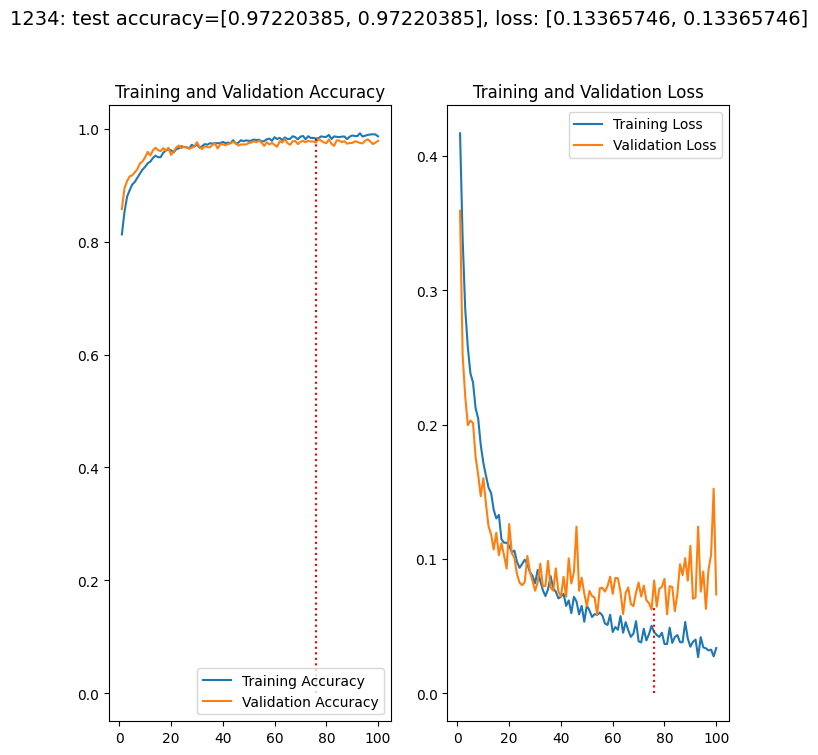

In [43]:
test_loss3, test_acc3 = trainer3.test()
print(f"Augmented Model - Test Loss: {test_loss3:.4f}, Test Accuracy: {test_acc3 * 100:.2f}%")

trainer3.plot_performance(name="task4_model_augmented", group_no=3)
plt.savefig("task4_model_augmented.png")
print("Performance plot saved as task4_model_augmented.png")

***
#### Q5: Look at the performance of the third model over time, what do you observe compared to the first two models? Explain underfitting/overfitting based on your plots.

#### Performance analysis
##### Validation Loss
- Augumented model decreases to the lowest value among all models and remains stable, demonstrating the best generalization.
##### Validation Accuracy
- Augumented model shows the highest validation accuracy and maintains stability throughout training.
##### Test Accuracy
- Simple model: 94.77%
- Regularized model: 95.17%
- Augmented model: 97.22%
##### Underfititng and Overfitting
- Underfitting happens when a model cannot capture underlying patterns, this is not visible in any of the models because they all end up succesfully learnig to improve during trainig. If that wasnt the case the traing and validation accuracy would be low, and the training and validation loss would remain high throughout.
- Overfitting happens when the model learns the training data with too many irelevant details. It can be seen the best in the simple model because the validation perfomance stagnates and loss flucutates. In the augumented model the overfitting is very low, because of better generalization , it can be seen because the test has the highest validation and test accuracy.

#### 4.5 Activation Maps after Training
During training the weights of the model are adapted to the feature distribution of the training dataset. Plot some activation maps of the third model again using ***utils.plot_activation_maps(..)***. Use the same image samples you used before.

***Submission:*** Save the activation maps after the training as **task4_mask_activation_maps_after.png** and **task4_face_activation_maps_after.png** using ***utils.plot_activation_maps(..)***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total convolutional layers: 2
Total convolutional layers: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Activation maps saved successfully.


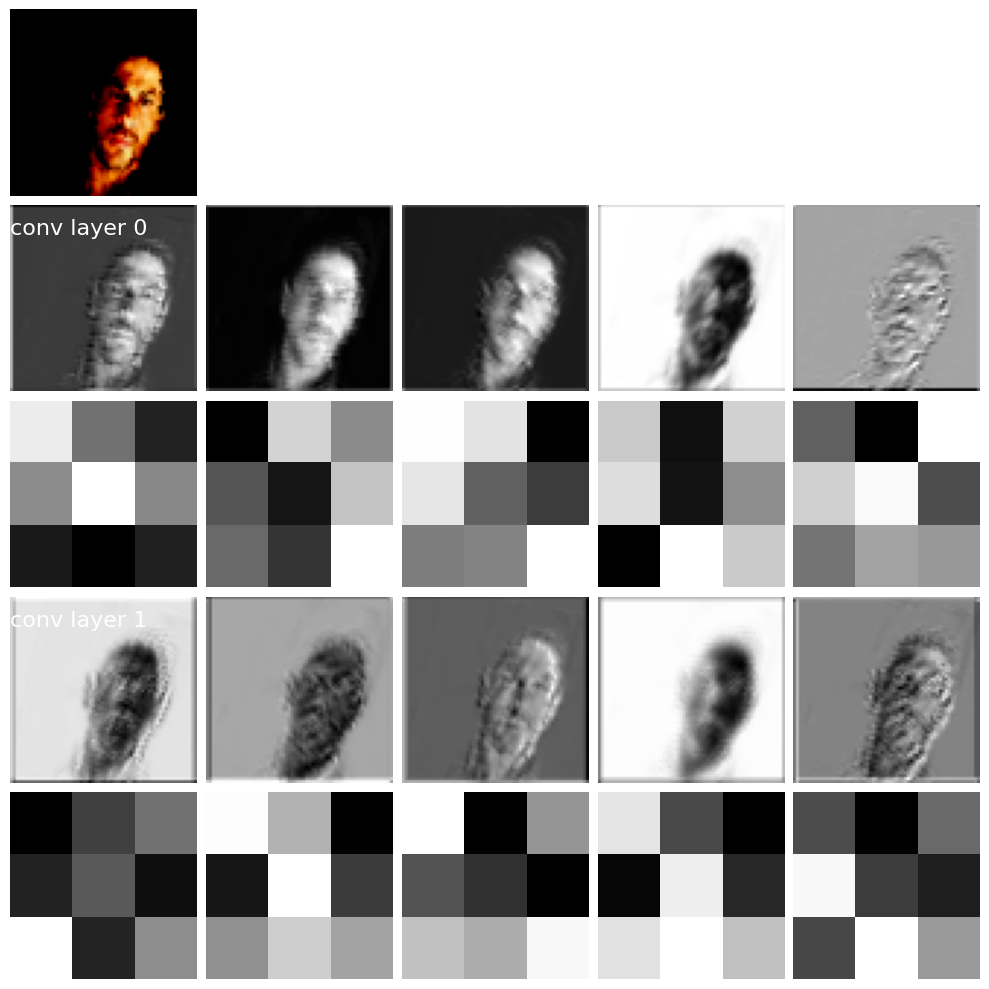

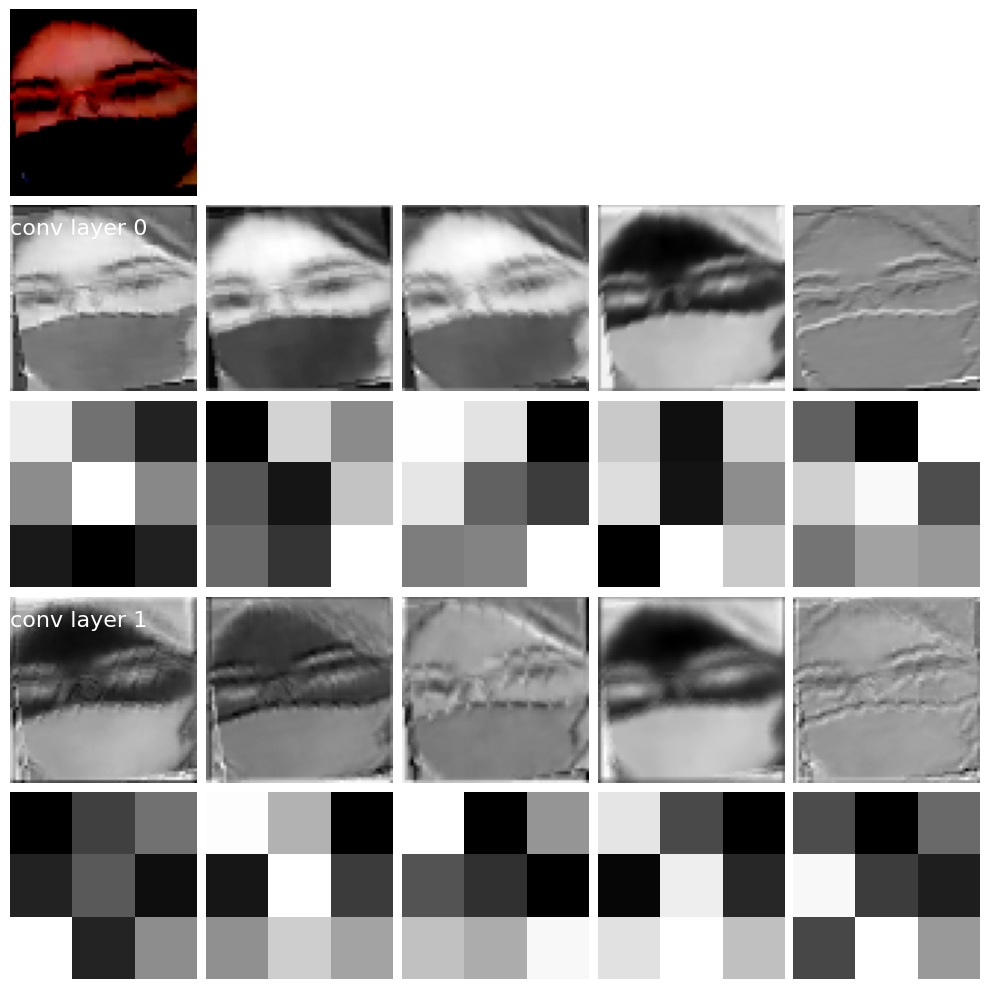

In [49]:

from utils import plot_activation_maps
import matplotlib.pyplot as plt


sample_with_mask = data_module_augmented.train_dataset[0][0]
sample_without_mask = data_module_augmented.train_dataset[3456][0]

plot_activation_maps(model_augmented, sample_with_mask, "task4_mask_activation_maps_after")
plot_activation_maps(model_augmented, sample_without_mask, "task4_face_activation_maps_after")

plt.savefig("task4_mask_activation_maps_after.png")
plt.savefig("task4_face_activation_maps_after.png")
print("Activation maps saved successfully.")

***
#### Q6: The activations and filter kernels after the training have changed, what do you observe? Explain possible reasons.


#ANSWER HERE 

### 5 Evaluation

Calculate the confusion matrix. You can use the function **confusion_matrix** from **sklearn.metrics**. A confusion matrix within a binary decision problem shows:
 - "true positive" for correctly predicted event values.
 - "false positive" for incorrectly predicted event values.
 - "true negative" for correctly predicted no-event values.
 - "false negative" for incorrectly predicted no-event values.

You can obtain the test data and labes by using **X, y = next(iter(dm2.text_dataloader()))**. Use **trainer3.predict(X)** to obtain the predicted value. You can convert a tensor to a numpy array by using **y.detach().numpy()**. 

Confusion Matrix:
[[741  25]
 [ 17 728]]


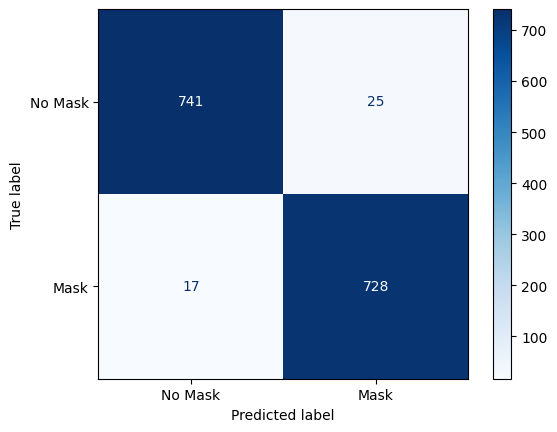

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

X, y = next(iter(data_module_augmented.test_dataloader()))

y_pred = trainer3.predict(X)

y_pred = (y_pred > 0.5).astype(int)  

y_true = y.detach().numpy().astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Mask", "Mask"])
disp.plot(cmap="Blues")


***
#### Q7: Compare the approach for classification from TASK3 and TASK4. Discuss advantages, disadvantages, strength and weakness. 


#ANSWER HERE